In [1]:
from qiskit_braket_provider import AWSBraketProvider
from braket.aws import AwsSession

aws_session = AwsSession(default_bucket="amazon-braket-us-west-1-lukasvoss")
AWSBraketProvider().backends()

[BraketBackend[Aria 1],
 BraketBackend[Aria 2],
 BraketBackend[Aspen-M-3],
 BraketBackend[Forte 1],
 BraketBackend[Harmony],
 BraketBackend[Lucy],
 BraketBackend[SV1],
 BraketBackend[dm1]]

In [2]:
import numpy as np
import sys
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
module_path = os.path.abspath(os.path.join('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control'))
if module_path not in sys.path:
    sys.path.append(module_path)

from template_configurations import gate_q_env_config
from quantumenvironment import QuantumEnvironment
from gymnasium.wrappers import RescaleAction, ClipAction

import logging
logging.basicConfig(
    level=logging.WARNING,
    format="%(asctime)s INFO %(message)s", # hardcoded INFO level
    datefmt="%Y-%m-%d %H:%M:%S",
    stream=sys.stdout,
)

/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(
I0000 00:00:1707971564.149642       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Circuit context
global phase: π
     ┌──────────┐┌────────┐                    ┌──────────┐┌────────┐
q_0: ┤ Ry(-π/2) ├┤ Rz(-π) ├──■────■────■────■──┤ Ry(-π/2) ├┤ Rz(-π) ├
     └──────────┘└────────┘┌─┴─┐  │    │    │  └──────────┘└────────┘
q_1: ──────────────────────┤ X ├──┼────┼────┼────────────────────────
                           └───┘┌─┴─┐  │    │                        
q_2: ───────────────────────────┤ X ├──┼────┼────────────────────────
                                └───┘┌─┴─┐  │                        
q_3: ────────────────────────────────┤ X ├──┼────────────────────────
                                     └───┘┌─┴─┐                      
q_4: ─────────────────────────────────────┤ X ├──────────────────────
                                          └───┘                      
Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
Starting Rabi experiment for qubit 1...
Rabi

/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit_experiments/calibration_management/calibrations.py:1391: UserWarning: Schedules are only saved in text format. They cannot be re-loaded.
  warnings.warn("Schedules are only saved in text format. They cannot be re-loaded.")


In [3]:
# Define the original action space
print('Initial lower bounds:', gate_q_env_config.action_space.low)
print('Initial upper bounds:', gate_q_env_config.action_space.high)

q_env = QuantumEnvironment(gate_q_env_config)

# Apply the RescaleAction wrapper
q_env = ClipAction(q_env)
q_env = RescaleAction(q_env, min_action=-1.0, max_action=1.0)

# Confirm the rescale box dimensions
print('Rescaled lower bounds:', q_env.action_space.low)
print('Rescaled upper bounds:', q_env.action_space.high)

Initial lower bounds: [-3.14 -3.14 -3.14 -3.14 -3.14 -3.14 -3.14]
Initial upper bounds: [3.14 3.14 3.14 3.14 3.14 3.14 3.14]
Rescaled lower bounds: [-1. -1. -1. -1. -1. -1. -1.]
Rescaled upper bounds: [1. 1. 1. 1. 1. 1. 1.]


In [4]:
gate_name = q_env.target['gate'].name
gate_name

/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.target to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.target` for environment variables or `env.get_wrapper_attr('target')` that will search the reminding wrappers.
  logger.warn(


'cx'

In [5]:
print(q_env.backend)

BraketBackend[SV1]


/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.backend to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.backend` for environment variables or `env.get_wrapper_attr('backend')` that will search the reminding wrappers.
  logger.warn(


In [6]:
from helper_functions import load_agent_from_yaml_file
agent_config  = load_agent_from_yaml_file(file_path='/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/agent_config.yaml')

In [7]:
agent_config

{'RUN_NAME': 'test',
 'NUM_UPDATES': 1,
 'N_EPOCHS': 8,
 'MINIBATCH_SIZE': 10,
 'LR': 0.0005,
 'GAMMA': 0.99,
 'GAE_LAMBDA': 0.95,
 'ENT_COEF': 0.0,
 'V_COEF': 0.5,
 'GRADIENT_CLIP': 0.5,
 'CLIP_VALUE_LOSS': True,
 'CLIP_VALUE_COEF': 0.2,
 'CLIP_RATIO': 0.2,
 'OPTIMIZER': 'adam',
 'N_UNITS': [64, 64],
 'ACTIVATION': 'tanh',
 'INCLUDE_CRITIC': True,
 'NORMALIZE_ADVANTAGE': True,
 'CHKPT_DIR': 'checkpoints'}

In [8]:
from ppo import make_train_ppo

ppo_agent = make_train_ppo(agent_config, q_env)

/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(
/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.batch_size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.batch_size` for environment variables or `env.get_wrapper_attr('batch_size')` that will search the reminding wrappers.
  logger.warn(
/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.tgt_instruction_counts to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can 

In [9]:
num_updates = 200

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
training_results = ppo_agent(total_updates=3, print_debug=True, num_prints=40, max_cost=10)

  0%|          | 0/3 [00:00<?, ?it/s]

Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[ 0.25+0.j,  0.25+0.j, -0.25+0.j, -0.25+0.j])


 33%|███▎      | 1/3 [01:51<03:42, 111.22s/it]

Finished Estimator job
mean tensor([-0.0720,  0.0866,  0.1202, -0.0954,  0.0235,  0.0380, -0.0161])
sigma tensor([0.5077, 0.5196, 0.4778, 0.4882, 0.5024, 0.4788, 0.4748])
DFE Rewards Mean: 0.4130769230769231
DFE Rewards standard dev 0.26500083733260593
Returns Mean: 0.6614018
Returns standard dev 0.5468718
Advantages Mean: 0.6336674
Advantages standard dev 0.5468718
Starting benchmarking...
Starting simulation benchmark...
Avg gate fidelity: 0.2595756073670481
Finished simulation benchmark
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[ 0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j])


 67%|██████▋   | 2/3 [03:37<01:48, 108.10s/it]

Finished Estimator job
mean tensor([-0.0065,  0.1061,  0.0780, -0.0412, -0.0279,  0.0436,  0.0163])
sigma tensor([0.4856, 0.5174, 0.4878, 0.4677, 0.5310, 0.4685, 0.4567])
DFE Rewards Mean: 0.3321212121212121
DFE Rewards standard dev 0.26549051921736627
Returns Mean: 0.5112754
Returns standard dev 0.5076024
Advantages Mean: 0.34877384
Advantages standard dev 0.5076024
Starting benchmarking...
Starting simulation benchmark...
Avg gate fidelity: 0.28250548464664693
Finished simulation benchmark
Finished benchmarking
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[ 0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j])


100%|██████████| 3/3 [05:26<00:00, 108.80s/it]

Finished Estimator job
mean tensor([-0.0029,  0.1070,  0.0621, -0.1226, -0.0102,  0.0748,  0.0201])
sigma tensor([0.4511, 0.5216, 0.4833, 0.4683, 0.5390, 0.4455, 0.4606])
DFE Rewards Mean: 0.33375
DFE Rewards standard dev 0.2615638067470345
Returns Mean: 0.54716074
Returns standard dev 0.6541105
Advantages Mean: 0.19945711
Advantages standard dev 0.6541105


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time

plt.style.use('ggplot')

In [13]:
avg_reward = training_results['avg_reward']
std_actions = training_results['std_actions']
fidelities = training_results['fidelities']

In [14]:
job_name = f'{gate_name}-gate-calibration-{int(time.time())}-max-fidelity-{round(max(fidelities), 5)}.pickle'

In [15]:
job_name = f'{gate_name}-gate-calibration-{int(time.time())}-max-fidelity-{max(fidelities):4%}.pickle'

with open(job_name, 'wb') as handle:
    pickle.dump(training_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
print(f'Final Gate Fidelity: {fidelities[-1]:.4%}')
print(f'\nMax Gate Fidelity: {max(fidelities):.4%}')

Final Gate Fidelity: 28.2505%

Max Gate Fidelity: 28.2505%


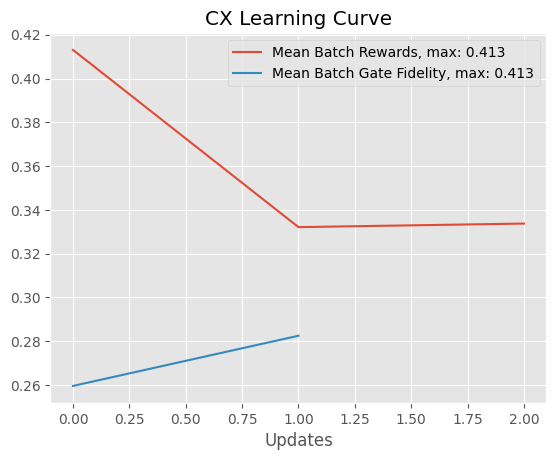

In [17]:
reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

fidelity = np.array(q_env.avg_fidelity_history)
mean_fidelity = np.mean(fidelity, axis=-1)
max_fidelity = int(np.max(mean_rewards) * 1e4) / 1e4

plt.plot(mean_rewards, label=f'Mean Batch Rewards, max: {max_mean}')
plt.plot(q_env.avg_fidelity_history, label=f'Mean Batch Gate Fidelity, max: {max_fidelity}')
plt.xlabel('Updates')
plt.title('CX Learning Curve')
plt.legend()
plt.show()

Parameter 1 Std Dev: 0.481484979391098
Parameter 2 Std Dev: 0.5195518334706625
Parameter 3 Std Dev: 0.4829605023066203
Parameter 4 Std Dev: 0.4747328559557597
Parameter 5 Std Dev: 0.5241397619247437
Parameter 6 Std Dev: 0.4642483393351237
Parameter 7 Std Dev: 0.4640246629714966


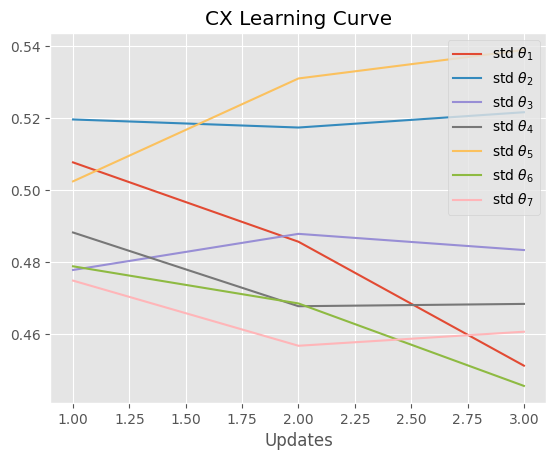

In [24]:
std_actions_componentwise = list(zip(*std_actions))

for ind, param in enumerate(std_actions_componentwise):
    print(f'Parameter {ind+1} Std Dev: {np.mean(param)}')
    plt.plot(np.arange(1, num_updates+1), param, label=r'std $\theta_{}$'.format(ind+1))

plt.title('CX Learning Curve')
plt.xlabel('Updates')
plt.legend()

In [ ]:
print('Final action vector:\n', training_results['action_vector'])